# Практическое домашнее задание - 4

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg
import scipy.sparse.linalg as spla
import time
%matplotlib inline

## Расчёт напряжений в системе резисторов

В этой задаче мы поработаем с разреженными системами, в том числе научимся быстро пересчитывать решение при изменениях ранга 1 в матрице левой части.

При конструировании сверхбольших интегральных схем (СБИС, very large scale integration, VLSI) одной из базовых задачей является расчёт напряжений в электрических схемах довольно внушительных размеров. Мы рассмотрим модельный пример: сетку $m \times n$ с резисторами сопротивления $R$.

![](https://teachs.ru/images/question/41a0210c5b8a09c9ca58319c1ab1ce18.png)

Потенциалы в узлах сетки обозначим $\varphi_{ij}$, это и будут наши неизвестные. Давайте также считать, что к противоположным углам сетки ($(1,1)$ и $(m,n)$) приложена разность потенциалов $U$. Соответственно, в левый верхний угол втекает (неизвестный) ток $I$, и такой же ток вытекает из правого нижнего угла.

Для решения системы нам будет достаточно закона Ома и первого закона Кирхгофа. Именно, для каждого резистора легко выразить текущий через него ток. Например, для горизонтального резистора между узлами $(i,j)$ и $(i,j+1)$ ток равен $I_{i,j} = (\varphi_{ij} - \varphi_{i,j+1})/R$. Далее применяем первый закон Кирхгофа для каждого узла $(i,j)$, то есть приравниваем сумму втекающих токов к сумме вытекающих. Для внутреннего узла получим такое равенство:
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R} = 0.\tag{1}
$$
На границе, например, верхней (то есть $i = 1$), будет отсутствовать член $\varphi_{i-1,j}-\varphi_{i, j}$, а в углу, например, $(1,n)$, будет дополнительно отсутствовать член $\varphi_{i,j}-\varphi_{i, j+1}$. В углах $(1,1)$ и $(m, n)$, однако, ситуация особая: в первом есть дополнительный втекающий неизвестный ток $I$, а во втором этот же ток вытекает.
В результате получим систему на $\varphi_{i,j}$ и $I$:
$$
\left[ \begin{array}{ccccc|c}
   &&   && &  R \\
   &&   && &  0 \\
   && A && &  \vdots  \\
   &&   && &  0 \\
   &&   && & -R \\
   \hline
1 & 0 & \dots &  0 & -1 & 0
\end{array}
\right]
\begin{bmatrix}
\varphi_{11} \\
\vdots       \\
\vdots       \\
\vdots       \\
\varphi_{mn}  \\
I
\end{bmatrix}
=
\begin{bmatrix}
0 \\
\vdots       \\
\vdots       \\
\vdots       \\
0  \\
U
\end{bmatrix}
$$
Последнее уравнение есть $\varphi_{11}-\varphi_{mn} = U$.

Разберёмся с видом матрицы $A$. Она имеет размеры $mn \times mn$ и индексируется двумя парами индексов $ij$ и $i'j'$. Перепишем уравнение (2) в виде
$$
(\varphi_{i,j-1} - 2\varphi_{i,j} + \varphi_{i,j+1}) + (\varphi_{i-1,j} - 2\varphi_{i,j} + \varphi_{i+1,j}) = 0.\tag{2}
$$
Если переписать столбец $\varphi$ с элементами $\varphi_{ij}$ в матрицу $\Phi\in\mathbb{R}^{m \times n}$ естественным образом (то есть так, чтобы $\mathrm{vec}(\Phi) = \varphi$), то ясно, что первое слагаемое в (2) действует на столбцы матрицы $\Phi$, а второе &mdash; на строки. То есть $A \varphi  = \mathrm{vec}(\Phi A_n) + \mathrm{vec}(A_m \Phi)$, где $A_n \in \mathbb{R}^{n \times n}$ и $A_m \in \mathbb{R}^{m \times m}$ имеют вид
$$
\begin{bmatrix}
-1 & 1 & &  \\
1 & -2 & 1 & \\
  &   & \ddots &  \\
  &     &    1 & -1
 \end{bmatrix}.
$$
По уже известной нам формуле для $\mathrm{vec}(\cdot)$ получается, что $A = A_n \otimes I_m + I_n \otimes A_m$. Операция в правой части ещё называется *Кронекеровой суммой* матриц $A_n$ и $A_m$ и обозначается $A_n \oplus A_m$ (можете проверить, что такая "сумма" не имеет такого интуитивного свойство суммы, как коммутативность, т.е. в общем случае $A_m \oplus A_n \neq A_n \oplus A_m$).

**Обратите внимание**, что система получилась линейно зависимой: если сложить все строки, кроме последней, получится нулевая строка (физически это отвечает тому, что все потенциалы можно сдвинуть на одинаковую константу).
Поэтому мы удалим предпоследнюю строку (не потеряв никакой информации, ведь она равнялась минус сумме остальных), а вместо неё добавим условие $\varphi_{mn} = 0$, таким образом фиксируя один из потенциалов, чтобы уничтожить неопределённость. Обозначим получившуюся $(mn+1)\times(mn+1)$ матрицу $B$.

### 1. Разреженное LU-разложение (20 баллов)

a. (**12 баллов**) Сформируйте разреженную матрицу решаемой системы в CSC формате. Для получения матриц $A_m, A_n$ используйте `scipy.sparse.spdiags`, а для сбора $A$ по $A_m, A_n$ используйте `scipy.sparse.kron` матрицы $A$. Обратите внимание, что в этом задании нельзя собирать $A$ или $A_m, A_n$ с использование операций с плотными матрицами.

In [2]:
from scipy import sparse

def make_A(m, n):
    "Returns sparse mn x mn matrix A"
    diag = np.array([0,1,-1])
    main_diag1 = np.array([-1] + [-2]*(n-2) + [-1])
    main_diag2 = np.array([-1] + [-2]*(m-2) + [-1])
    other_diags1 = np.ones(n)
    other_diags2 = np.ones(m)
    data1 = np.array([main_diag1, other_diags1, other_diags1])
    data2 = np.array([main_diag2, other_diags2, other_diags2])
    A_n = scipy.sparse.spdiags(data1, diag, n, n)
    A_m = scipy.sparse.spdiags(data2, diag, m, m)
    return scipy.sparse.kron(A_n, scipy.sparse.identity(m)) + scipy.sparse.kron(scipy.sparse.identity(n), A_m)

def make_mat(m, n, R):
    "Returns sparse (mn + 1) x (mn + 1) matrix of the system in CSC format"
    B = scipy.sparse.csc_matrix((m*n + 1, m * n + 1))
    A = make_A(m, n)
    coo_A = A.tocoo()
    B[coo_A.row, coo_A.col] = coo_A.data
    B[m*n, 0] = 1
    B[m*n, m*n - 1] = -1
    B[m*n-1, m*n-1] = 1
    B[m*n-1, m*n-2] = 0
    B[0, m*n] = R
    return B


b. (**8 баллов**) Заполните класс `Solver`, который при инициализации выполнит разреженное LU-разложение с помощью библиотеки `scipy.sparse.linalg` и функции `scipy.sparse.linalg.splu`, а затем будет уметь решать систему для заданной правой части.

In [3]:
import scipy.sparse.linalg

class Solver:
    def __init__(self, m, n, R):
        self.B = scipy.sparse.linalg.splu(make_mat(m, n, R))
        self.m = m
        self.n = n
        self.R = R

    def solve(self, right):
        "Solves the system for given right part"
        return self.B.solve(right).reshape(-1, 1)

    def solve_voltage(self, U):
        "Solves the updated system for given voltage"
        right_part = np.array([0] * self.n * self.m + [U])
        return self.solve(right_part)


Решим систему и визуализируем полученное решение, чтобы понять, как текут токи.

In [4]:
def visualize(m, n, R, solution, resistance_coeffs={}):
    plt.axis('off')
    plt.gcf().set_size_inches((n, m / 2))
    max_current = 0
    lines = []
    for i in range(m):
        for j in range(n - 1):
            current = (solution[j * m + i] - solution[(j + 1) * m + i]) / R
            dx = 0.2 if current > 0 else -0.2
            plt.arrow(j+0.5, -i, dx, 0, shape='full', lw=2, length_includes_head=True, head_width=.10, color='blue')
            max_current = max(max_current, current)
            lines += plt.plot([j, j + 1], [-i, -i], color='blue', lw=abs(current))
    for i in range(m - 1):
        for j in range(n):
            resistance = R * resistance_coeffs.get((i, j), 1)
            current = (solution[j * m + i] - solution[j * m + i + 1]) / resistance
            dy = -0.1 if current > 0 else 0.1
            plt.arrow(j, -i - 0.5, 0, dy, shape='full', lw=2, length_includes_head=True, head_width=.08, color='blue')
            max_current = max(max_current, current)
            lines += plt.plot([j, j], [-i, -i - 1], color='blue', lw=abs(current))
    for l in lines:
        l.set_linewidth(l.get_linewidth() * 4. / max_current)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


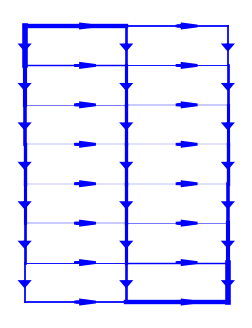

In [5]:
m, n, R = 8, 3, 1.
solver = Solver(m, n, R)
visualize(m, n, R, solver.solve_voltage(220.))

Проверьте, что ваш солвер работает для больших систем.

In [6]:
m, n, R = 500, 500, 1.
solver = Solver(m, n, R)
_ = solver.solve_voltage(220.)

### 2. Обновления ранга 1 (40 баллов)

Представим теперь, что в процессе работы резисторы в нашей системе могут менять своё сопротивление, например, при перегреве проводник может потерять проводимость ($R_{i,j} = \infty$) или, напротив, может произойти короткое замыкание ($R_{i,j} = 0$). При таких локальных изменениях нет нужды строить и решать заново всю нашу линейную систему.

a. (**17 баллов**) Будем считать для простоты, что
  1. сопротивление меняется только в вертикальных резисторах, не инцидентных узлам $(0,0)$ и $(m-1, n-1)$;
  2. в каждом проводе сопротивление может измениться только один раз.

Пусть сопротивление между узлами $(i,j)$ и $(i+1,j)$ изменилось с $R$ на $R'$. Пользуясь формулой (1), выпишите новую матрицу $B'$ в виде $B' = B + uv^\top$.


(можно написать решение в строчке ниже или на листке, который надо будет сфотографировать)

Запишем два уравнения для токов проходящих через $(i, j)$, $(i + 1, j)$\
1)Первое уравнение:
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R_{new}} = 0.\tag{1}$$\
Перепишем его:\
$$
(\varphi_{i,j-1} - 2\varphi_{i,j} + \varphi_{i,j+1}) + (\varphi_{i-1,j} - (1 + \frac{R}{R_{new}})\varphi_{i,j} + \frac{R}{R_{new}}\varphi_{i+1,j}) = 0.\tag{2}
$$

2)Второе уравнение:
$$
\frac{\varphi_{i+1,j-1} - \varphi_{i+1,j}}{R} + \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R_{new}} - \frac{\varphi_{i+1,j} - \varphi_{i+1,j+1}}{R} - \frac{\varphi_{i+1,j} - \varphi_{i+2,j}}{R} = 0.\tag{1}
$$
Перепишем его:\
$$
(\varphi_{i+1,j-1} - 2\varphi_{i+1,j} + \varphi_{i+1,j+1}) + (\frac{R}{R_{new}}\varphi_{i,j} - (1 + \frac{R}{R_{new}})\varphi_{i+1,j} + \varphi_{i+2,j}) = 0.\tag{2}
$$

Все остальные уравнения не изменились\
Тогда в матрице $A$ изменилась $i + mj$ строка и $i + 1 + mj$, к $i + mj$ и $i + mj + 1$ элементам этих строк добавились $\frac{R}{R_{new}} - 1$ и $1 - \frac{R}{R_{new}}$, это возмущение ранга 1, которое можно записать так:
$u = (0, \dots, 1, -1, \dots, 0)^{T}$, $v = (0, \dots, 1 - \frac{R}{R_{new}} \frac{R}{R_{new}} - 1, \dots, 0)^{T}$.\
$B' = B + uv^{T}$

Далее воспользуемся формулой Шермана-Моррисона для обращения матрицы $B + uv^\top$:
$$
(B + uv^\top)^{-1} = B^{-1} - \frac{B^{-1}uv^\top B^{-1}}{1 + v^\top B^{-1}u}.
$$

b. (**23 балла**) Напишите класс `UpdatableSolver`, использующий `Solver`, но вдобавок умеющий умножать сопротивление в заданном вертикальном резисторе на заданное число.

In [7]:
class UpdatableSolver:
    def __init__(self, m, n, R):
        self.init_solver = Solver(m, n, R)
        self.vecs = []

    def solve(self, right):
        return self.recursive_solve(right)

    def recursive_solve(self, right, start_arr = 0, end_arr = None):
        if end_arr is None:
          end_arr = len(self.vecs)
        if end_arr == 0:
          return self.init_solver.solve(right)
        else:
          prev_solve = self.recursive_solve(right, start_arr=0, end_arr=end_arr - 1)
          y, v, coeff = self.vecs[end_arr-1]
          return prev_solve - y @ (v.T @ prev_solve) * coeff

    def update(self, i, j, coeff):
        """
            Updates the system so that the resistance between (i,j) and (i+1,j)
            is mutiplied by coeff.
        """
        u1 = np.zeros(self.init_solver.n * self.init_solver.m + 1)
        u1[i + j * self.init_solver.m] = 1
        u1[i + j * self.init_solver.m + 1] = -1
        u1 = u1.reshape(-1, 1)

        v1 = np.zeros(self.init_solver.n * self.init_solver.m + 1)
        v1[i + j * self.init_solver.m] = 1 - 1/coeff
        v1[i + j * self.init_solver.m + 1] = 1/coeff - 1
        v1 = v1.reshape(-1, 1)
        vec_y = self.solve(u1)
        vec_y = vec_y.reshape(-1,1)

        self.vecs.append((vec_y, v1, 1/(1 + v1.T @ vec_y)))

    def solve_voltage(self, U):
        right_part = np.array([0] * self.init_solver.n * self.init_solver.m + [U])
        return self.solve(right_part)


Поэкспериментируем с изменением проводимости отдельных участков. Попробуем сильно увеличить сопротивление сначала одного, затем другого резистора в одном вертикальном ряду.

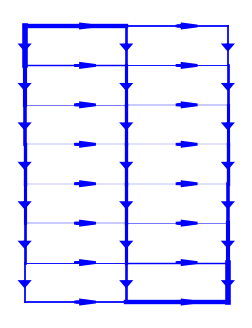

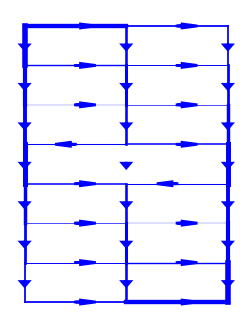

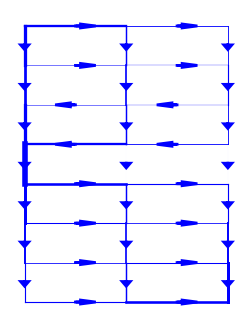

In [8]:
m, n, R = 8, 3, 1.
solver = UpdatableSolver(m, n, R)
visualize(m, n, R, solver.solve_voltage(220.))
plt.figure()
coeff = 1000
resistance_coeffs = {(3,1): coeff}
solver.update(3, 1, coeff)
visualize(m, n, R, solver.solve_voltage(220.), resistance_coeffs=resistance_coeffs)
plt.figure()
resistance_coeffs[(3,2)] = coeff
solver.update(3, 2, coeff)
visualize(m, n, R, solver.solve_voltage(220.), resistance_coeffs=resistance_coeffs)

Также проверим, что новый солвер работает для больших систем.

In [9]:
m, n, R = 300, 300, 1.
solver = UpdatableSolver(m, n, R)
solver.solve_voltage(220.)
solver.update(10, 20, 100.)
solver.update(20, 30, 100.)
solver.update(30, 40, 100.)
_ = solver.solve_voltage(220.)

## Итерационные методы для решения линейных систем

В этой задаче мы будем сравнивать различные итерационные методы для решения систем, как модельных, так и настоящих больших и разреженных.

### 3. Модельная плотная матрица (35 баллов)

Начнём с некоторой модельной плотной матрицы. Она будет симметричной положительно определённой, чтобы можно было применять все наши методы, однако собственные числа мы выберем так, чтобы получить довольно большое число обусловленности.

In [10]:
d = np.hstack([1 / np.arange(100, 0, -1), 10])
n = len(d)
Q, _ = np.linalg.qr(np.random.random((n, n)))
A = (Q * d) @ Q.T
b = np.random.random(n)

На всякий случай нарисуем сингулярные числа.

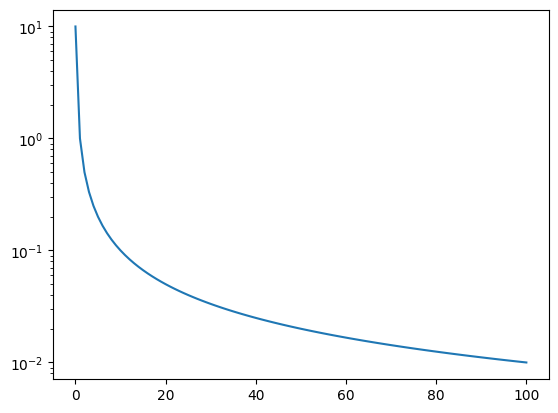

In [11]:
plt.plot(np.linalg.svd(A, compute_uv=False))
_ = plt.semilogy()

#### a. Метод простой итерации (15 баллов)

Реализуйте функцию, которая обобщает все варианты метода простой итерации. За это обобщение отвечает параметр `get_dx` &mdash; функция, принимающая невязку $r_k$ и возвращающая вектор $\Delta x \equiv x_{k+1} - x_k$.
Также у функции есть параметр `tol`, соответствующий целевой относительной невязке, то есть величине $\|r_k\|_2/\|b\|_2$.
Наконец, параметр `debug` нужен, чтобы контролировать дебажный вывод. Если передан `debug=True`, на каждой итерации нужно печатать (в свободной форме) номер итерации, относительную невязку и всё, что ещё сочтёте интересным.

В выходном параметре `residual_norms` необходимо вернуть список относительных величин невязок для каждой итерации.

In [12]:
def simple_iteration(A, b, get_dx, x0=None, tol=1e-5, max_iter=None, debug=False):
    """
        Input
            A: dense or sparse square matrix
            b: right part of appropriate size
            get_dx: function computing correction to current solution from current residualresidue
            x0: initial guess for solution
            tol: relative residualresidue to achieve
            max_iter: if specified, no more that this number of iterations will be performed
            debug: if True, output iteration no. and relative residualresidue norm (||r||_2/||b||_2) at each iteration

        Output
            x: found approximate solution
            residual_norms: relative residualresidue norms at each iteration
    """
    residual_norms = []
    if x0 is None:
      x_current = np.random.randn(n)
    else:
      x_current = x0
    num_iter = 1
    while (max_iter is None or num_iter < max_iter):
      r_current = b - A.dot(x_current)
      residual_norms += [np.linalg.norm(r_current)/np.linalg.norm(b)]
      if debug is True:
        print(f"Текущая относительная невязка - {r_current}")
      if np.linalg.norm(r_current)/np.linalg.norm(b) < tol:
        return x_current, residual_norms

      x_current += get_dx(r_current)
      num_iter += 1
    return x_current, residual_norms


Используем также вспомогательную функцию, которая будет запускать солвер, печатать время работы и рисовать график сходимости.

In [13]:
def run_solver(solver, A, b, make_get_dx, **kwargs):
    start = time.time()
    get_dx = make_get_dx()
    get_dx_time = time.time()
    x, rs = solver(A, b, get_dx, **kwargs)
    finish = time.time()
    print("Runtime: {:4.2f} secs ({:4.2f} preparation + {:4.2f} iters)".format(
        finish - start,
        get_dx_time - start,
        finish - get_dx_time,
    ))
    if not rs:
        return None, finish - start
    line = plt.plot(rs)
    plt.xlabel("Iteration no.")
    plt.ylabel("Relative residualresidue")
    _ = plt.semilogy()
    return line, finish - start

#### b. Метод Ричардсона (5 баллов)

Начнём с метода Ричардсона. Реализуйте функцию `make_richardson_get_dx(A, tau)`, которая возвращает функцию, соответствующую методу Ричардсона (Richardson iteration) с фиксированным параметром $\tau$.

In [14]:
def make_richardson_get_dx(A, tau):
    """
        Input
            A: square matrix
            tau: parameter of Richardson iteration

        Output
            get_dx: function mapping r to Δx corresponding to Richardson iteration
    """
    return lambda x: x*tau

Помня, что старшее и младшее собственные (и сингулярные) числа матрицы $A$ равны $10$ и $10^{-2}$ соответственно,
выберите 4 разных варианта для $\tau$ из интервала, в котором гарантируется сходимость метода, включая оптимальное значение $\tau$. Прокомментируйте полученный результат.

Runtime: 0.40 secs (0.00 preparation + 0.40 iters)
Runtime: 0.38 secs (0.00 preparation + 0.38 iters)
Runtime: 0.39 secs (0.00 preparation + 0.39 iters)
Runtime: 0.40 secs (0.00 preparation + 0.40 iters)


<ipython-input-15-e698b9f58e66>:8: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  _ = plt.legend(lines, labels)


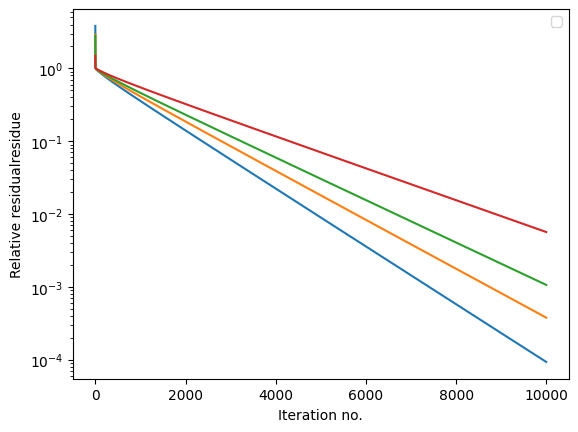

In [15]:
taus = [1/11, 1/13, 1/15, 1/20]
lines = []
labels = []
for tau in taus:
    line, _ = run_solver(simple_iteration, A, b, lambda: make_richardson_get_dx(A, tau), max_iter=10000)
    lines.append(line)
    labels.append("$\\tau = {:4.2f}$".format(tau))
_ = plt.legend(lines, labels)

**YOUR WORDS GO HERE**

Видно что в каждом из вариантов относительная ошибка с определенного момента начинает убывать, на 10000 итерации она уже около $10^{-4}$, что логично, так как для всех таких значений метод ричардсона сходится.

Также попробуйте 1 вариант вне интервала, в котором гарантируется сходимость. Например, отступите от границы интервала на 0.01. Прокомментируйте полученный результат.

<ipython-input-12-3d721248c182>:30: RuntimeWarning: invalid value encountered in add
  x_current += get_dx(r_current)


Runtime: 1.02 secs (0.00 preparation + 1.02 iters)


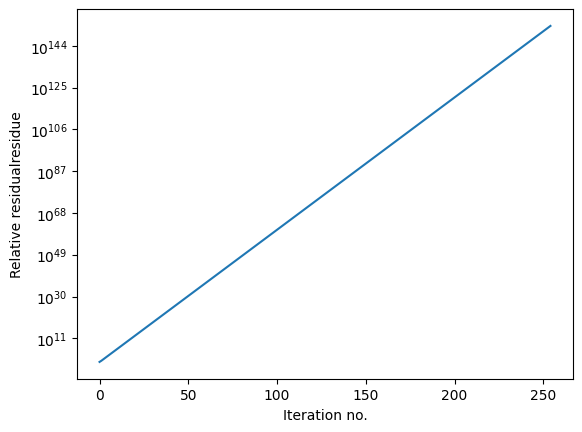

In [16]:
outsider_tau = [1/2]
_ = run_solver(simple_iteration, A, b, lambda: make_richardson_get_dx(A, outsider_tau), max_iter=10000)

В данном случае относительная ошибка начинает расти очень быстро, так как ряд неймана расходится

**YOUR WORDS GO HERE**

#### c. Метод Якоби (5 баллов)
Реализуйте функцию `make_jacobi_get_dx(A)`, которая возвращает функцию, соответствующую методу Якоби (то есть $g_{\mathrm{JAC}}(r) = \mathrm{diag}(A)^{-1}r$).

In [17]:
def make_jacobi_get_dx(A, sparse = False):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to Jacobi method
    """

    if sparse is False:
      diagonal_values = 1 / np.diag(A)
      diag_mat = np.diag(diagonal_values)
    else:
      diagonal_values = A.diagonal()
      diag_mat = scipy.sparse.diags(diagonal_values, format='csr')


    return lambda x: diag_mat.dot(x)

Запустим метод на нашей матрице. Объясните (неформально) полученный результат.

Runtime: 0.01 secs (0.00 preparation + 0.01 iters)


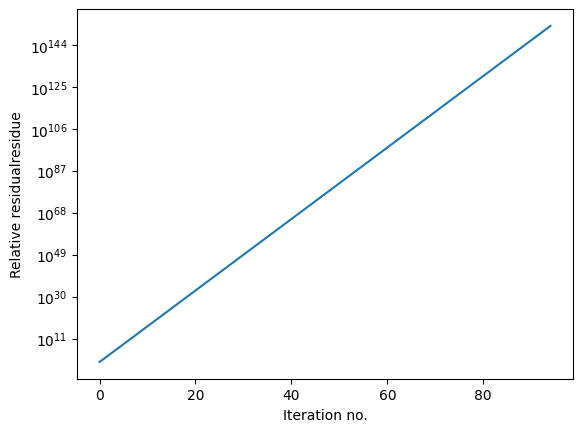

In [18]:
_ = run_solver(simple_iteration, A, b, lambda: make_jacobi_get_dx(A), max_iter=100)

In [19]:
for i in range(A.shape[0]):
  sum_i = np.sum(np.abs(A[i]))
  print(np.abs(A[i][i]), sum_i - np.abs(A[i][i]))

0.061530231907747486 2.609116857408966
0.07840176334701347 3.489239646896654
0.0612166518957109 2.7177765629615505
0.049140405081618765 0.8675847651692126
0.12684617759572142 6.296808467345346
0.07824058159760434 4.737097263557348
0.07733067507205717 4.180395183241502
0.0640632529258709 2.997769438747304
0.3906388405287406 14.104307626150995
0.06874415139466894 1.5025022120505565
0.14169076126542815 6.1417371125595706
0.14285952387067355 7.3592299928368945
0.15950216402951284 6.016835353106837
0.07327540019653096 2.547776044681327
0.0341309997254102 0.6912183119489743
0.3532220972273328 13.178937976177
0.044466500059632624 1.7866702004413604
0.055875329269828806 2.4399301591024405
0.037214944368922726 1.290723284002445
0.05371015500854956 3.6936906558051237
0.10862009866803626 5.722427207742229
0.041707718835705676 1.1379957014648912
0.07101566387652876 2.7321537355568606
0.11159489062450506 6.487174610924196
0.05509927598247445 3.502490299589969
0.3670713760460167 13.398672561583673
0

Можно видеть что для матрицы не выполняется диагональное доминирование, так что расхождение метода якоби вполне логично

**YOUR WORDS GO HERE**

#### d. Метод Гаусса-Зейделя (5 баллов)

Реализуйте функцию `make_gauss_seidel_get_dx(A)`, которая возвращает функцию `get_dx`, соответствующую методу Гаусса-Зейделя.

In [20]:
def make_gauss_seidel_get_dx(A):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to Gauss--Seidel method
    """
    L_A = np.tril(A)
    inv_L_A = np.linalg.inv(L_A)
    return lambda x: inv_L_A.dot(x)

Запустим метод.

Runtime: 0.52 secs (0.01 preparation + 0.51 iters)


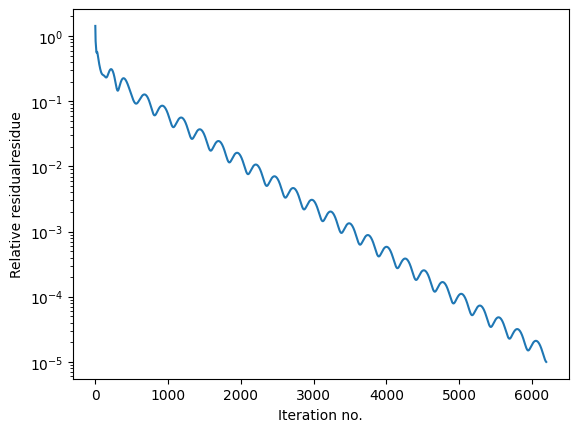

In [21]:
_ = run_solver(simple_iteration, A, b, lambda: make_gauss_seidel_get_dx(A))

#### e. Метод скорейшего спуска (5 баллов)

Реализуйте функцию `make_steepest_descent_get_dx(A)`, которая возвращает функцию, соответствующую методу скорейшего спуска.

In [22]:
def make_steepest_descent_get_dx(A):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to steepest descent method
    """
    return lambda x: x * (np.linalg.norm(x.T.dot(x))/ np.linalg.norm(x.T.dot(A.dot(x))))

Запустим метод скорейшего спуска.

Runtime: 0.11 secs (0.00 preparation + 0.11 iters)


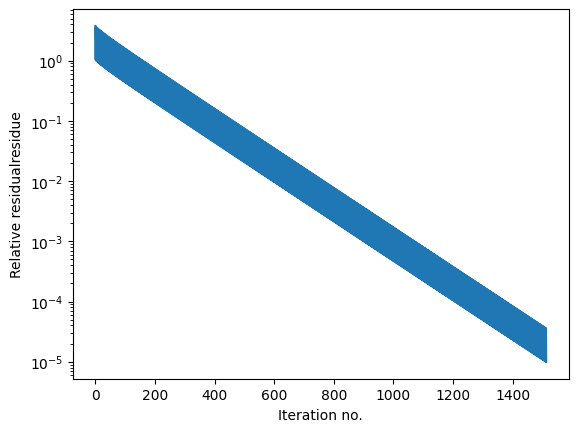

In [23]:
_ = run_solver(simple_iteration, A, b, lambda: make_steepest_descent_get_dx(A))

### 4. Применение к большим разреженным матрицам (5 баллов)

До сих пор больших проблем со сходимостью методов на тестовой матрице не возникало. Но в практических задачах могут возникать весьма неприятные матрицы. Давайте скачаем [файл G2_circuit.mat](https://sparse.tamu.edu/AMD/G2_circuit) (для удобства мы уже положили его в одну папку с данным ноутбуком; по ссылке можно ознакомиться с шаблоном разреженности матрицы и ее графом) с некоторой разреженной матрицей из коллекции разреженных матриц Флоридского университета https://sparse.tamu.edu. Отметим, что выбранная матрица соответствует некоторой задаче физической симуляции работы интегральной схемы (вероятно из процессора AMD).

На сайте коллекции можно не только сортировать матрицы по размерам и числу ненулевых элементов, но и фильтровать по разным свойствам. Например, упомянутая матрица является симметричной положительно определённой, что будет нам очень на руку.

Загрузим файл (он в матлабовском формате .mat, но scipy справится). Также выберем некоторый случайный вектор в качестве правой части.

In [24]:
import scipy.io
A = scipy.io.loadmat("G2_circuit.mat")["Problem"][0][0][2]
assert A.shape[0] == A.shape[1]
n = A.shape[0]
print("{} x {}, nnz: {}, density: {:.3}".format(n, n, A.nnz, A.nnz / float(n**2)))
b = np.random.random(n)

150102 x 150102, nnz: 726674, density: 3.23e-05


Примените какой-нибудь (на ваш выбор) из реализованных выше методов простой итерации к данной задаче. При запуске ограничьте максимальное число итераций с помощью параметра `max_iter`. Сделайте выводы.

Я решил потестить два метода, якоби и метод скорейшего спуска

Runtime: 64.56 secs (0.00 preparation + 64.56 iters)


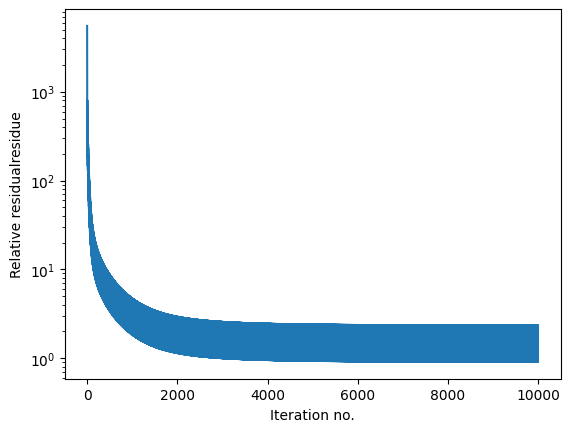

In [26]:
_ = run_solver(simple_iteration, A, b, lambda: make_steepest_descent_get_dx(A), max_iter = 10000)

Видно, что метод градиентного спуска хоть и улучшает результат на каждой итерации, с определенного момента темп убывания ошибки очень сильно уменьшается на значении относительной ошибки около 1, видимо скорейший спуск застрял в локальном оптимуме.

<ipython-input-12-3d721248c182>:30: RuntimeWarning: invalid value encountered in add
  x_current += get_dx(r_current)


Runtime: 11.26 secs (0.05 preparation + 11.21 iters)


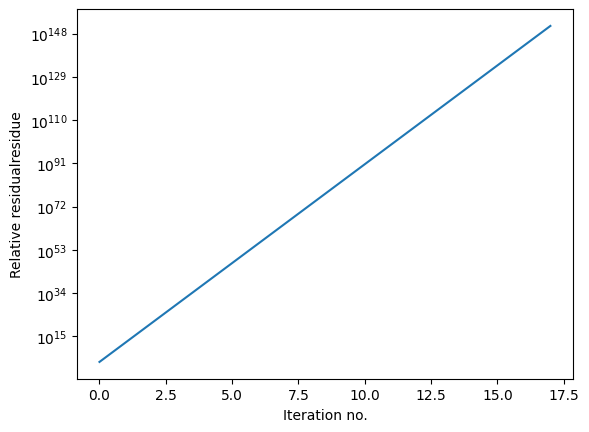

In [28]:
_ = run_solver(simple_iteration, A, b, lambda: make_jacobi_get_dx(A, sparse = True), max_iter = 1000)

Еще я метод якоби, так как изначально он выглядел наиболее подходящим(элементы на диагонали положительные в силу положительной определенности, при этом в самой матрице много нулей, так что скорее всего имеет место диагональное доминирование), к сожалению несмотря на это якоби расходится



В следующем практическом ДЗ мы попробуем применить к этим же задачам метод сопряжённых градиентов и прочие крыловские методы.